**Complete the details below:**

### Name: Elan van Biljon


#### Student Number: 18384439

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Import different modules for using with the notebook
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from IPython.display import HTML
from IPython.display import display
from IPython.display import Image

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans
from sklearn.mixture import GMM

from numpy.random import randint
from kmeans_resource import Kmeans as KM
from skimage import io
from ipywidgets import interact

from scipy.stats import multivariate_normal
from sklearn.mixture import GaussianMixture as GMM_new
from sklearn.semi_supervised import label_propagation
import itertools

import warnings
warnings.filterwarnings('ignore')

### Perform $k$-means on an image
### Clustering of colors

* **Use 3 colors to represent the image.** 

* **How many clusters do you need for a perfect reproduction?**

**Mark:** 1

I closely followed the tutorial found at:<br>

http://scikit-learn.org/stable/auto_examples/cluster/plot_color_quantization.html#sphx-glr-auto-examples-cluster-plot-color-quantization-py

In [3]:
# Define function to recreate the image (Code exactly from tutorial)
def recreate_image(codebook, labels, w, h):
    """Recreate the (compressed) image from the code book & labels"""
    d = codebook.shape[1]
    image = np.zeros((w, h, d))
    label_idx = 0
    for i in range(w):
        for j in range(h):
            image[i][j] = codebook[labels[label_idx]]
            label_idx += 1
    return image

In [4]:
# Read in cartoon
cartoon = io.imread('./cartoon.png')

# Convert cartoon to normalised np array
cartoon = np.array(cartoon, dtype=np.uint8) / 255

# Get cartoon dimentions (width, height, channels/depth)
w, h, d = original_shape = tuple(cartoon.shape)

# Flatten the width and height while preserving the depth
flat_cartoon = cartoon.reshape((w * h, d))

In [5]:
# function that uses kmeans to do vector quantization - displays output
def image_vec_quantize(n_vec, flat_image, return_image=False):
    # Create and fit Kmeans model
    model = KMeans(n_clusters=n_vec, init='k-means++',
                   n_init=(5-np.int(np.log(n_vec))))
    means = model.fit(flat_image)

    # Predict new colors for image (may only be one of means)
    new_colors = means.predict(flat_image)

    # Create new cartoon using the function above and the new means
    new_image = recreate_image(means.cluster_centers_, new_colors, w, h)
    
    if(return_image):
        return new_image
    else:
         # Display the new image
        plt.figure()
        plt.title('Reconstruction using %d colors' % n_vec)
        plt.imshow(new_image)
        plt.show()

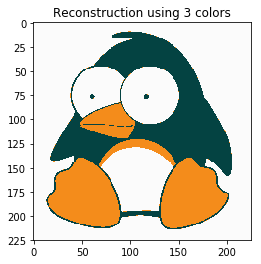

In [6]:
image_vec_quantize(3, flat_cartoon)

We can see that the reconstruction using only 3 colors is actually very good.<br>
Now let us investigate how many colors are needed for a perfect reconstruction.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 ...

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]]


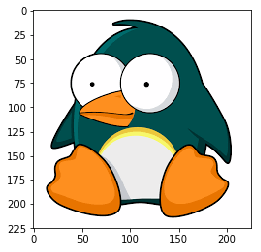

In [7]:
# flatten the cartoon so that it is just a color (RGB) row vecotrs 
flat_cartoon = cartoon.reshape((1, -1, 3))[0, :, :]

# create a np array that contains all the unique color row vectors
unique_color_vectors = np.vstack({tuple(row) for row in flat_cartoon})

# get the number of vectors in this array
n_color_no_loss = unique_color_vectors.shape[0]

# display a reconstruction of the image using this number of colors
a = image_vec_quantize(n_color_no_loss, flat_cartoon, True)
print(a)
plt.figure() 
plt.imshow(a)
plt.show()

As expected, this reconstruction looks exactly like the original cartoon. But is it really necessary to use that many colors?<br>
Let's find out:

In [8]:
# create a series of reconstructions with a different number of colors
n_cartoons = 20
n_colors = 20
n_cols = np.linspace(1, n_colors, n_cartoons).astype(int)
cartoons = [
    image_vec_quantize(n_col, flat_cartoon, True)
    for n_col in n_cols
]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

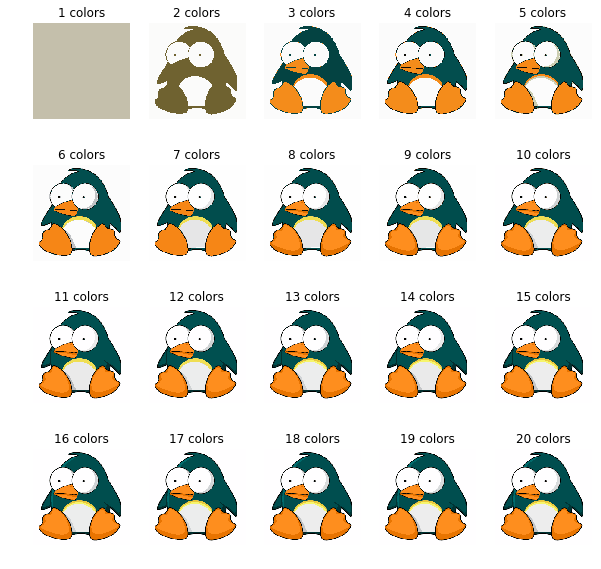

In [9]:
# Plot these reconstructions
fig = plt.figure(figsize=(10, np.ceil(n_cols.size/2)))
count = 0
for i in n_cols:
    ax = fig.add_subplot(np.ceil(n_cols.size/5), 5, 1 + count)
    ax.imshow(cartoons[count])
    count+=1
    plt.title('%d colors' % i)
    plt.axis('off')
plt.show()

It is clear that a reconstruction that looks identical to the original to our eyes is possible with much less colors. Due to the random nature of the algorithm, the above (and below) images will not always be the same when running the program. Thus I do not know how good the reconstruction is that the reader sees, but I have observed a visually perfect reconstruction with as few as 14 colors.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


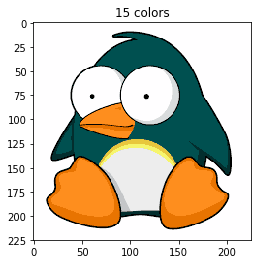

In [10]:
n_plot = 14
plt.figure()
plt.title('%d colors' % (n_plot + 1))
plt.imshow(cartoons[n_plot])
plt.show()

# Clustering of digits data
### Load the digit datasets

The datasets are loaded into a dictionary.

In [11]:
# Import `datasets` from `sklearn`
from sklearn import datasets

# Load in the `digits` data
digits = datasets.load_digits()

In [12]:
# Find the number of unique labels
number_digits = len(np.unique(digits.target))

# Project onto 2 PCA components

**Use the scikit-learn module and project the digits data onto 2 principal components. Display the clusters in different colors using the known labels.**

**Marks:** 1

In [13]:
# Create a regular PCA model
pca = PCA(n_components=2)

# Flatten the data so that it can be fed into the PCA model
flat = digits.images.reshape((digits.images.shape[0], 1, -1))
flat = flat[:, 0, :]

# Fit and transform the data to the model
pca.fit(flat)
reduced_data_pca = pca.transform(flat)

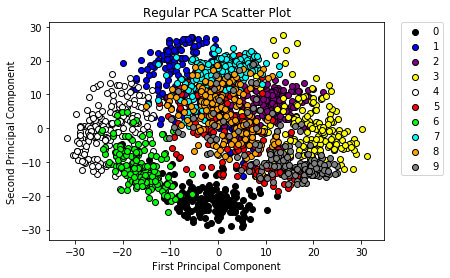

In [14]:
colors = ['black', 'blue', 'purple', 'yellow',
          'white', 'red', 'lime', 'cyan',
          'orange', 'gray']
for i in range(len(colors)):
    x = reduced_data_pca[:, 0][digits.target == i]
    y = reduced_data_pca[:, 1][digits.target == i]
    plt.scatter(-x, -y, c=colors[i], edgecolor='black')
plt.legend(digits.target_names, bbox_to_anchor=(1.05, 1),
           loc=2, borderaxespad=0.)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title("Regular PCA Scatter Plot")
plt.show()

We can see that using PCA we could get decent class separation between **some** of the digits, but **definitely not when looking at all the digits**.

# LDA

**Now do the same as for PCA but now project onto 2 LDA components to get the following:**

**Marks: 0**

In [15]:
# Create a regular LDA model
lda = LDA(n_components=2)

# Get labels
labels = digits.target

# Fit and transform the data to the model
lda.fit(flat, labels)
reduced_data_lda = lda.transform(flat)

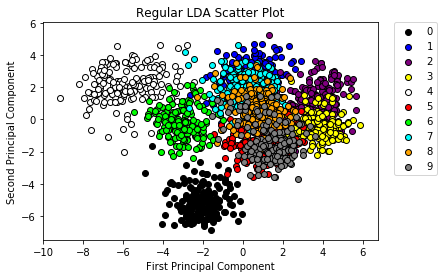

In [16]:
colors = ['black', 'blue', 'purple', 'yellow',
          'white', 'red', 'lime', 'cyan',
          'orange', 'gray']
for i in range(len(colors)):
    x = reduced_data_lda[:, 0][digits.target == i]
    y = reduced_data_lda[:, 1][digits.target == i]
    plt.scatter(x, y, c=colors[i], edgecolor='black')
plt.legend(digits.target_names, bbox_to_anchor=(1.05, 1),
           loc=2, borderaxespad=0.)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title("Regular LDA Scatter Plot")
plt.show()

LDA is designed to deliver a lower dimension projection of the data that ensures the greatest class separation. Unfortunately, the above plot shows that LDA has not given a much better projection of the data (in terms of class separation). This shows us that the data cannot be accurately represented (and divided into classes) in 2 dimensions. Later in this report I will explore how many dimensions one would need to accurately divide the data into classes.

# Clustering the digits data
### Split the data into test and training sets

scikit-learn provides a convenient function to split given data into training, validation and test sets in its model_selection package.  Let's do that first.

In [17]:
# Import `train_test_split`
from sklearn.model_selection import train_test_split

# Split the `digits` data into training and test sets
X_train, X_test, y_train, y_test, images_train, images_test =\
train_test_split(digits.data, digits.target,
                 digits.images, test_size=0.25,
                 random_state=42)

In [18]:
# Number of training features
n_samples, n_features = X_train.shape
n_digits = np.unique(y_train).size

### K-means model

**Create the k-means model and display the means.**

**Marks:** 0

I closely followed the tutorial found at:<br>

http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html#sphx-glr-auto-examples-cluster-plot-kmeans-digits-py

In [19]:
# function for easy plotting of digits
def plot_digits(digits, title):
    # Figure size in inches
    fig = plt.figure(figsize=(10, 4))

    # Add title
    fig.suptitle(title, fontsize=14, fontweight='bold')

    # For all labels (0-9)
    for i in range(10):
        # Initialize subplots in a grid of 2X5, at i+1th position
        ax = fig.add_subplot(2, 5, 1 + i)
        # Get dimension
        d = np.sqrt(digits[i].shape[0])
        # Display images
        ax.imshow(digits[i].reshape((d, d)), cmap=plt.cm.binary)
        # Don't show the axes
        plt.axis('off')

    # Show the plot
    plt.show()

In [20]:
# Create the KMeans model
model = KMeans(n_clusters=n_digits, init='k-means++', random_state=42)

# Fit the training data to the model
means = model.fit(X_train)

# Retrieve the cluster centres
cluster_centers = means.cluster_centers_

TypeError: 'numpy.float64' object cannot be interpreted as an integer

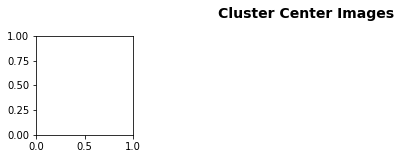

In [21]:
plot_digits(cluster_centers, 'Cluster Center Images')

These means look quite good. One fairly easily distinguish each digit, with the occasional exception of the eight and the one. Those two digits can rather easily be confused.

# Confusion matrix

**Predict the labels using the k-means model you created above. Compare against the known labels using a confusion matrix.**

**Explain what you see, and comment on the accuracy of the predicted labels.** 

**Marks: 1**<br>

plotting function got from:<br>

http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

In [ ]:
# function to plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
# function that displays the confusion matrix stats
def confusion_matrix_stats(model, data, labels, axis, title=None):
    # Predict the labels for `data`
    predicted_labels = model.predict(data)

    # Print out the confusion matrix with `confusion_matrix()`
    con_mat = confusion_matrix(labels, predicted_labels)

    plt.figure()
    if title:
        plot_confusion_matrix(con_mat, axis, title=title)
    else:
        plot_confusion_matrix(con_mat, axis)

In [ ]:
# confusion matrix of training data
confusion_matrix_stats(means, X_train, y_train, ['N/A']*10,
                       'Confusion Matrix of trianing data')

In [ ]:
confusion_matrix_stats(means, X_test, y_test, ['N/A']*10,
                      'Confusion Matrix of test data')

From the confusion matrix we have no (trivial) way of knowing which cluster (or mean) corresponds to a given digit.<br>

There are other problems with the confusion matrix than the format of it. We can see that there are digits that the model has some trouble distinguishing between. We can see this when there are rows or columns with similar intensity (or magnitude of number) colored squares.

# Really bad 

* **Next initialize the k-means algorithm by providing one random sample from each class as the initial mean estimate for each cluster.**

* **Again plot the class means as above, predict the labels of the training data, and show the confusion matrix. Is there any improvement?**

**Marks: 1**

In [ ]:
# Get a random example from each class
rand_estimates = np.zeros((10, 64))

for i in np.arange(0, 10):
    X_i = X_train[y_train == i]
    rand_example = X_i[randint(0, X_i.shape[0]-1)]
    rand_estimates[i] = rand_example

# Plot the initial mean estimates
plot_digits(rand_estimates, 'Random Estimates - Initial Means')
    
# Create the KMeans model
model = KMeans(n_clusters=n_digits, init=rand_estimates,
               n_init=1, random_state=42)

# Fit the training data to the model
means = model.fit(X_train)

# Retrieve the cluster centres
cluster_centers = means.cluster_centers_

# Plot means and confusion matrix
plot_digits(cluster_centers, 'Cluster Center Images')
confusion_matrix_stats(means, X_test, y_test, np.arange(10))

This confusion matrix is better because the format of the data is conserved and one can read off the model predictions very easily, and the model seems to be find better cluster centers more consistently.<br>

We can see that the accuracy of the model is greatly dependent on the initial examples given to the model. If the model is given a 'good' example of the class as an initial value, it tends to be accurate. I the model is given a 'bad' example of the class as an initial value, the model tends to do poorly.<br>

The model sometimes has trouble predicting 3 (often mistaken for a 9), 1 (often mistaken for an 8 or 9) and 5 (often mistaken for a 9) accurately. This is quite understandable when we look at the cluster centers for the classes. The cluster centers are often an inaccurate representation of the class.<br>

While this model cannot take in multiple initial mean examples, one could simulate this in a way by getting multiple examples of each class and calculating the mean of the data for each class. You could then feed this into the model as it's initial mean.

# Semi-supervised training

In [ ]:
# Random initialization 
km = KM(codes=10,itr=20)
km.fit(X_train)
cluster_centers = km.get_means

In [ ]:
plot_digits(cluster_centers, 'Cluster Center Images')

# Creating Data

In [ ]:
# The number of samples per class
n_samples = 2

# The same number of samples is generated for each class. This is just
# a convenience, any number will do. Note: Assume at least one sample for 
# each class
X_lbl = np.zeros((10*n_samples,64))
y_lbl = np.zeros((10*n_samples,))
for i in range(10):
    dat = X_test[y_test==i,:]
    samples = np.random.randint(0,dat.shape[0]-1,n_samples)

    X_lbl[i*n_samples:(i+1)*n_samples] = dat[samples]
    y_lbl[i*n_samples:(i+1)*n_samples] = i

plot_digits(X_lbl[::n_samples], 'Labeled Images');

#### Modify code

* **Modify the given k-means code to allow semi-supervised learning.**
* **Predict the labels in the training set and print the confusion matrix.**

**Marks:** 4<br>

3 missing lines:<br>

1st pass block: `means = self.init_means_lbl_(X_label, y)`<br>

2nd pass block: `dat = np.vstack([dat, X_label[y == i]])`<br>

3rd pass block: `means[i] = np.mean(X_label[y == i], axis=0)`<br>

In [ ]:
# 3 missing lines:
def missing_code():
    return
    # first pass:
    means = self.init_means_lbl_(X_label, y)
    # second pass:
    dat = np.vstack([dat, X_label[y == i]])
    # third pass:
    means[i] = np.mean(X_label[y == i], axis=0)

In [ ]:
km = KM(codes=10,itr=20)
km.fit(X_train,X_lbl,y_lbl)
km_cluster_centers = km.get_means

In [ ]:
plot_digits(km_cluster_centers, 'Cluster Center Images');

These cluster centers look like very good representations of the data. These results are far better than the case of using pure unsupervised learning.

# Confusion matrix

In this case we don't have the identifiability problem as indicated by the confusion matrix.

In [ ]:
confusion_matrix_stats(km, X_train, y_train, np.arange(10),
                      'Confusion Matrix of training data')

In [ ]:
confusion_matrix_stats(km, X_test, y_test, np.arange(10),
                      'Confusion Matrix of test data')

We can see from the confusion matrix that this model is far more accurate than the unsupervised k-means model. This model can distinguish between digits far more easily and accurately.<br>

This shows the power of having just a very small amount of labeled data. With just 2 examples of each class to use in a supervised manner we were able to increase the model's accuracy considerably.<br>

I would have liked investigate how the accuracy changes as you increase the number of examples you use in a supervised manner, but due to time constraints I am not able to.

# GMM

* **Next, fit the data to a 10 component GMM model, using the scikit-learn package.**
* **Once you have built the GMM model, extract the means as well as the covariances of the 10 GMM components. Display the means to get something like the  image below.**

**Marks: 1**

In [22]:
data = digits.data

np.random.seed(1)
gmm = GMM(n_components=10)
gmm.fit(data)
gmm_means = gmm.means_

TypeError: 'numpy.float64' object cannot be interpreted as an integer

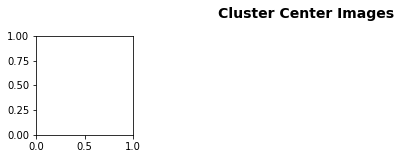

In [23]:
plot_digits(gmm_means, 'Cluster Center Images')

These cluster centers are about as good as the unsupervised k-means model's cluster centers.

In [ ]:
confusion_matrix_stats(gmm, X_test, y_test, ['N/A']*10)

The GMM seems to have the same problems as the unsupervised k-means model. The confusion matrix format is off and and the accuracy of the model is too low.<br>

This begs the question: "Why would we the want to use a GMM?"<br>

We know that GMM's take far longer to train and by this example we can see that they are not always better.<br>

There are actually multiple reasons for using GMM's over k-means models. The first of which is that it is not constrained by linear decision boundaries. The k-means model classifies points with a nearest neighbour approach (hard classifications) and the GMM uses the cluster centers and the class covariances to calculate the probability of a given observation being in each class (soft classifications). This allows a GMM to have non-linear decision boundaries and fit more complex data.<br>

Another reason to use GMM is because it gives us a distribution over our data. This allows us to generate samples of our data:

# Generate samples

* **Use the means and covariances of the different components and draw a sample from each component.**
* **Display the samples in an image.**

**Marks:** 1

In [ ]:
# function that returns generated samples
def gen_samples(mean, covar):
    samples = [
            multivariate_normal.rvs(
            mean=mean[i],
            cov=covar[i]
        )
        for i in np.arange(10)
    ]
    return samples

In [ ]:
gmm_covars = gmm.covars_
samples = gen_samples(gmm_means, gmm_covars)

In [ ]:
plot_digits(samples, 'Generated Sample Images')

We can see that these generated examples are not very good. If we try hard we can distinguish which digit is which (the digits in decreasing order or ease is: 0, 6, 5, 3, 9, 8, 4, 7, 2, 1). However, the GMM does not seem to be able to generate good examples of each class. This is not unexpected as the GMM was not very accurate at clustering the digits in the first place. Later in the report I will explore ways of increasing the accuracy of a GMM and coaxing a GMM to generate better examples.

# EXTRAS
**Check true dimensionality of digit data:**

In [ ]:
# Create a regular PCA model
pca = PCA(n_components=64)

# Fit and transform the data to the model
pca.fit(flat)

plt.figure()
plt.title('Explained Variance ratio')
plt.xlabel('number of principle components')
plt.plot(range(1, 65), pca.explained_variance_ratio_)
plt.show()

From the explained variance ratio calculated by the PCA model we can clearly see that the digit data is not 2 dimensional. There is a fairly vast amount of information lost in the higher principle components. There seems to be very little information contained in principle components above the 20th principle component. Thus if I had to choose a lower dimensional subspace to represent the digits it would be roughly a 20 dimensional subspace.<br>

Let us look at the explained variance ratio calculated by the LDA model.

In [ ]:
# Create a regular LDA model
lda = LDA(n_components=9)

# Fit and transform the data to the model
lda.fit(flat, labels)

plt.figure()
plt.title('Explained Variance ratio')
plt.xlabel('number of principle components')
plt.plot(range(1, 10), lda.explained_variance_ratio_)
plt.show()

This plot makes it even more clear that the digits data cannot be accurately represented in a 2 dimensional subspace. It is important to note that the nature of the LDA model is such that you cannot have more principle components than the number of classes (the maximum amount is one less than the number of classes). Thus we are forced to use a much lower dimensional subspace than we would use if we used a PCA model. However it seems that it is possible to represent the digit data in a lower dimensional subspace that would conserve a great deal of the information and maximize class separation.<br>

Let's see what happens when we use unsupervised learning to classify this lower dimension data:<br>

First we split the data into a training and a test set (same with the labels):

In [ ]:
lda_digits = lda.transform(flat)

split_index = lda_digits.shape[0] * 0.8
lda_digit_train = lda_digits[:split_index]
labels_train = labels[:split_index]
lda_digit_test = lda_digits[split_index:]
labels_test = labels[split_index:]

Then we fit a k-means model to the training data and have a look at the models accuracy.

In [ ]:
model = KMeans(n_clusters=n_digits, init='k-means++')
means = model.fit(lda_digit_train)
confusion_matrix_stats(means, lda_digit_test, labels_test, ['N/A']*10)

It is clear that this dimensionality reduction has made it far easier for the model to find accurate cluster centers. We can see this as every column and row has a single square that has a much larger magnitude than the rest.<br>

For the sake of visualization we can feed the model some random initial means:

In [ ]:
# Get a random example from each class
rand_estimates = np.zeros((10, 9))
for i in np.arange(0, 10):
    X_i = lda_digit_train[labels_train == i]
    rand_example = X_i[randint(0, X_i.shape[0]-1)]
    rand_estimates[i] = rand_example
    
model = KMeans(n_clusters=n_digits, init=rand_estimates, n_init=1)
means = model.fit(lda_digit_train)
confusion_matrix_stats(means, lda_digit_test, labels_test, np.arange(10))

Giving the model initial mean values has increased it's accuracy slightly and lets us easily see that the model is performing very well.<br>

Let's see how the GMM does when given the lower dimensional data:

In [ ]:
gmm = GMM_new(n_components=10)
gmm.fit(lda_digit_train)
confusion_matrix_stats(gmm, lda_digit_test, labels_test, ['N/A']*10)

The GMM performs almost exactly as well as the k-means model that was not given initial means. This is quite impressive as the GMM trained on the full dimensional data was not as accurate as the k-means that was trained on the full dimensional data.<br>

**What was the point of this?**<br>

From this we see that we can improve the effectiveness of these unsupervised models by using LDA. But not only can we improve the accuracy, we can save a large amount of time. These models (especially the GMM) can take a long time to train and the training time goes up quite drastically as the dimensionality of the data increases. Thus we can get more accurate models, in less time! That sounds like a win all around to me!<br>

It should be mentioned that this method has its downsides. Once one has reduced the dimensionality of the data using LDA, you cannot re-project the data back into the higher dimension. Thus we cannot do this if we want to train a GMM to be able to generate class examples (that are more accurate representative of the data) that are in the higher dimensional space.<br>

**Compare sklearn semi-supervised learning to our semi-supervised k-means**<br>

http://scikit-learn.org/stable/auto_examples/semi_supervised/plot_label_propagation_digits_active_learning.html#sphx-glr-auto-examples-semi-supervised-plot-label-propagation-digits-active-learning-py

In [ ]:
# remove all labels except 2 for each class
n_examples = 2
y_partial = np.zeros(y_train.shape) - 1
for i in np.arange(10):
    count = 0
    index = 0
    while(count < n_examples):
        if(y_train[index] == i):
            y_partial[index] = i
            count += 1
        index += 1

# Train and get the accuracy of the model
model = label_propagation.LabelSpreading(gamma=0.25, max_iter=5)
model.fit(X_train, y_partial)
confusion_matrix_stats(model, X_test, y_test, np.arange(10))

It is interesting to see how much more accurate this model seems to be than ours. If I had more time I would delve into this library and find out why this is.<br>

**Give initial values to the GMM**<br>

But first I thought it would be interesting to compare the old GMM library (the one used above) to the new one (the one used from now on).

In [ ]:
np.random.seed(1)
gmm = GMM_new(n_components=10)
gmm.fit(X_train)
gmm_means = gmm.means_

plot_digits(gmm_means, 'Cluster Center Images')

confusion_matrix_stats(gmm, X_test, y_test, ['N/A']*10)

gmm_covars = gmm.covariances_
samples = gen_samples(gmm_means, gmm_covars)

plot_digits(samples, 'Generated Sample Images')

It is interesting to note that the new GMM library seems to be slightly more accurate, again, if I had more time I would try figure out why that is.

In [ ]:
# Get a random example from each class
rand_estimates = np.zeros((10, 64))
for i in np.arange(0, 10):
    X_i = X_train[y_train == i]
    rand_example = X_i[randint(0, X_i.shape[0]-1)]
    rand_estimates[i] = rand_example

plot_digits(rand_estimates, 'Random Estimates - Initial Means')

gmm = GMM_new(n_components=10, means_init=rand_estimates)
gmm.fit(X_train)
gmm_means = gmm.means_

plot_digits(gmm_means, 'Cluster Center Images')

confusion_matrix_stats(gmm, X_test, y_test, np.arange(10))

gmm_covars = gmm.covariances_
samples = gen_samples(gmm_means, gmm_covars)

plot_digits(samples, 'Generated Sample Images')

This result was initially very surprising to me. It seems that the GMM does quite badly when given initial means. I thought that perhaps the GMM would do better if I gave it better means, so I decided to give it the true means of the data as it's initial means.

In [ ]:
means = np.zeros((10, 64))
for i in np.arange(10):
    means[i] = np.mean(X_train[y_train == i], axis=0)

In [ ]:
plot_digits(means, 'Initial means Images')

gmm = GMM_new(n_components=10, means_init=km_cluster_centers)
gmm.fit(X_train)
gmm_means = gmm.means_

plot_digits(gmm_means, 'Cluster Center Images')

confusion_matrix_stats(gmm, X_test, y_test, np.arange(10))

gmm_covars = gmm.covariances_
samples = gen_samples(gmm_means, gmm_covars)

plot_digits(samples, 'Generated Sample Images')

This is even worse! At this point we need to think hard about what is happening in the GMM. It seems quite impossible that if we give it the actual means of the data that it can go this horribly wrong. That is until you remember that the GMM consists of 2 major sets of parameters: the cluster means and **the cluster covariance matrices**.<br>

I believe the following is happening:<br>

The means are being initialized correctly and the covariance matrices are being initialized somewhat randomly. Because of the class shape differences caused by the different covariance matrices:<br>

1. some classes will have many examples of the correct class assigned to it<br>

2. some classes will have many examples of the incorrect classes assigned to it<br>

3. some classes will have few examples of the correct class assigned to it<br>

4. some classes will have few examples of the incorrect classes assigned to it.<br>

We would like a combination of cases 1 and 2, however this is a somewhat unlikely event to occur when the model is initialized. A combination of the other events is far more likely and this is where the trouble comes.<br>

An important thing to remember is that the model is done being trained when the class centers and the covariance matrices stop changing significantly with each iteration of the EM algorithm. Thus if I initialize the model with the correct means and the incorrect covariance matrices (what has happened in the above case), the model will move farther and farther away from the true means as the class means must change with each iteration as the covariance matrices are attempting to be calculated. Thus the model will never finish the training with the correct means. Even if the model manages to find the correct covariance matrices, the model will still not be accurate as the means are wrong. This explains why we get worse results by initializing the model with the correct means.<br>

Another thing to keep in mind is some classes may be "stealing" data points from the correct class because of the shape of the covariance matrix (may enclose many values). Thus some classes may contain few examples of the correct class and be sure of their contents. And others may contain many examples of all classes and be unsure of it's contents. This could even force classes to have no data points inside of them (this may be what is happening above).<br>

We thus have 2 options:<br>

* initialize the model with a good estimation of the means and a good estimation of the covariance matrices<br>

* initialize the model with a good estimation of the means and an estimation of the covariance matrices that maximizes the chances of the classes containing many correct examples of the class and many incorrect examples of the class - in this case the EM algorithm will simply "shrink" the covariance matrices to fit mostly correct class examples and few incorrect class examples.<br>

I use the word "shrink" as it is helpful to visualize the covariance matrices as contour lines enclosing data points. As the EM algorithm does it's job these contours will change shape. In the above scenario the contours will get smaller to try exclude most of the incorrect class examples.<br>

Lets calculate the true covariance matrices for each class:<br>

Actually the GMM wants the precision matrices (inverse of the covariance matrices), thus I will calculate them if possible.

In [ ]:
covars = np.zeros((10, 64, 64))
precs = np.zeros((10, 64, 64))
precs_spherical = np.zeros((10, 64, 64))
for i in np.arange(10):
    dat = X_train[y_train == i]
    covars[i] = np.cov(dat.T)
    precs[i] = np.linalg.pinv(covars[i])
    precs_spherical[i] = np.diag(np.ones(64))

Let's see if I calculated the covariance matrices correctly:

In [ ]:
# generate samples using these means and covariances to check accuracy
samples = gen_samples(means, precs_spherical)
plot_digits(samples, 'Generated Sample Images')

It is clear than the covariance matrices and means are both correct as I can generate very good random examples of each class.<br>

This is, unfortunately, where we run into problems:

In [ ]:
for i in np.arange(10):
    print('Digit %d -' % i, end=' ')
    print('Rank is:', np.linalg.matrix_rank(covars[i]), end='; ')
    print('Is positive definite:', np.all(np.linalg.eigvals(covars[i]) > 0), end='; ')
    print('Is singular:', np.linalg.det(covars[i]) == 0)

The GMM requires the covariance matrices to be positive definite and it wants the precision matrices. This implies that the covariance matrices must be non-singular.<br>

We can see from the above results that none of the covariance matrices are positive definite and all of them are singular.<br>

This is a fairly big problem as this means we cannot initialize the GMM with the true covariance matrices.<br>

Thus I will initialize the GMM with spherical covariance matrices that follow the second case described above.<br>

In [ ]:
plot_digits(means, 'Initial means Images')

gmm = GMM_new(n_components=10, means_init=means,
              precisions_init=precs_spherical)
gmm.fit(X_train)
gmm_means = gmm.means_

plot_digits(gmm_means, 'Cluster Center Images')

confusion_matrix_stats(gmm, X_test, y_test, np.arange(10))

gmm_covars = gmm.covariances_
samples = gen_samples(gmm_means, gmm_covars)

plot_digits(samples, 'Generated Sample Images')

These results are very good! The class centers have only deviated slightly from the true means and the class covariance matrices seem to have taken on shapes very similar to the true covariance matrices. This is mainly shown by the accuracy displayed by the confusion matrix and the fact that the generated class examples are quite decent.<br>

Now let's see what happens if we initialize the GMM with the same spherical covariance matrices and a random example form each class (that may or may not be a good representation) as a mean.

In [ ]:
# Get a random example from each class
rand_estimates = np.zeros((10, 64))

for i in np.arange(0, 10):
    X_i = X_train[y_train == i]
    rand_example = X_i[randint(0, X_i.shape[0]-1)]
    rand_estimates[i] = rand_example

# Plot the initial mean estimates
plot_digits(rand_estimates, 'Random Estimates - Initial Means')

gmm = GMM_new(n_components=10, means_init=rand_estimates,
              precisions_init=precs_spherical)
gmm.fit(X_train)
gmm_means = gmm.means_

plot_digits(gmm_means, 'Cluster Center Images')

confusion_matrix_stats(gmm, X_test, y_test, np.arange(10))

gmm_covars = gmm.covariances_
samples = gen_samples(gmm_means, gmm_covars)

plot_digits(samples, 'Generated Sample Images')

We can see that this GMM is more likely to have a higher accuracy than a GMM that has not been initialized with any values. This is quite an important discovery and I feel like we have learned a lot through this process.<br>

This exercise leads me to believe that it is far more important to initialize the GMM with a "good" estimation of the covariance matrices than it is to initialize it with a good estimation of the means.<br>

**Have a look at the MNIST dataset with unsupervised learning:**

In [ ]:
from mnist import load_dataset
X_train, y_train, X_valid, y_valid, X_test, y_test = load_dataset()

X_train_flat = X_train.reshape((X_train.shape[0], -1))
X_test_flat = X_test.reshape((X_test.shape[0], -1))

**Unsupervised k-means:**

In [ ]:
km = KM(codes=10,itr=2)
km.fit(X_train_flat)
km_cluster_centers = km.get_means

In [ ]:
plot_digits(km_cluster_centers, 'Cluster Center Images');
confusion_matrix_stats(km, X_test_flat, y_test, np.arange(10))

The unsupervised k-means model is performing very poorly on the MNIST dataset.

**Semi-supervised k-means:**

In [ ]:
n_samples = 2
X_lbl = np.zeros((10*n_samples,X_train_flat.shape[1]))
y_lbl = np.zeros((10*n_samples,))
for i in range(10):
    dat = X_test_flat[y_test==i,:]
    samples = np.random.randint(0,dat.shape[0]-1,n_samples)

    X_lbl[i*n_samples:(i+1)*n_samples] = dat[samples]
    y_lbl[i*n_samples:(i+1)*n_samples] = i

plot_digits(X_lbl[::n_samples], 'Labeled Images');

In [ ]:
km = KM(codes=10,itr=2)
km.fit(X_train_flat,X_lbl,y_lbl)
km_cluster_centers = km.get_means

In [ ]:
plot_digits(km_cluster_centers, 'Cluster Center Images');
confusion_matrix_stats(km, X_test_flat, y_test, np.arange(10))

The semi-supervised k-means model only needs 2 class examples to greatly out perform the unsupervised k-means model.<br>

**Unsupervised GMM:**<br>

Note that `covariance_type='spherical'` was used as the model would take too long to train if any other setting is used (the MNIST dataset is quite large and is of very high dimensionality).

In [ ]:
gmm = GMM_new(n_components=10, n_init=10,
              covariance_type='spherical')
gmm.fit(X_train_flat)
gmm_means = gmm.means_

In [ ]:
plot_digits(gmm_means, 'Cluster Center Images')

confusion_matrix_stats(gmm, X_test_flat, y_test, ['N/A']*10)

gmm_covars = gmm.covariances_
samples = gen_samples(gmm_means, gmm_covars)

plot_digits(samples, 'Generated Sample Images')

We can see that the GMM is not very accurate. This is to be expected as we are trying to capture very complex relationships of high dimensional data with very few parameters.<br>

We may be able to improve the GMM's accuracy using what was learned above:

In [ ]:
precs_single = np.ones(10)
means = np.zeros((10, X_train_flat.shape[1]))
for i in np.arange(10):
    means[i] = np.mean(X_train_flat[y_train == i], axis=0)

In [ ]:
gmm = GMM_new(n_components=10,
              means_init=means,
              precisions_init=precs_single,
              covariance_type='spherical')
gmm.fit(X_train_flat)
gmm_means = gmm.means_

In [ ]:
plot_digits(means, 'True Class Means')

plot_digits(gmm_means, 'Cluster Center Images')

confusion_matrix_stats(gmm, X_test_flat, y_test, np.arange(10))

gmm_covars = gmm.covariances_
samples = gen_samples(gmm_means, gmm_covars)

plot_digits(samples, 'Generated Sample Images')

I was able to greatly increase the accuracy of the GMM but as previously stated, the GMM is still laking as we are trying to capture very complex relationships of high dimensional data with very few parameters.<br>

I could use the LDA investigation that was used above to improve the results but I feel that this has already been investigated and need not be done again.<br>

I would love to investigate many more things (such as how the means and covariance matrices change with each iteration of the EM algorithm, how the number of examples given to a semi-supervised model affects the accuracy) but unfortunately due to time constraints I must end here.<br>

# Plagiarism declaration

* I have read and understand the Stellenbosch University Policy on Plagiarism and the def- initions of plagiarism and self-plagiarism contained in the Policy [Plagiarism: The use of the ideas or material of others without acknowledgement, or the re-use of one’s own pre- viously evaluated or published material without acknowledgement or indication thereof (self-plagiarism or text- recycling)].
* I also understand that direct translations are plagiarism.
* Accordingly all quotations and contributions from any source whatsoever (including the
internet) have been cited fully.
* I understand that the reproduction of text without quotation marks (even when the source
is cited) is plagiarism.
* I declare that the work contained in this assignment is my own work and that I have not previously (in its entirety or in part) submitted it for grading in this module/assignment or another module/assignment.